<a href="https://colab.research.google.com/github/Priyanshiag1/Resnet_from_sratch/blob/main/another_copy_of_resnet_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-datasets

In [ ]:
import tensorflow_datasets as tfds
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [ ]:
cifar_builder = tfds.builder("cifar10")
cifar_builder.download_and_prepare()
print(cifar_builder.info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.SCQT38_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.SCQT38_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo nu

In [ ]:
print(cifar_builder.info.features["label"].names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
import math

# Some hyper-parameters:
input_shape = [32,32, 3]
batch_size  = 64            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 30           # Max number of training epochs

# Train/val Datasets:
train_cifar_dataset = cifar_builder.as_dataset(split=tfds.Split.TRAIN)
val_cifar_dataset = cifar_builder.as_dataset(split=tfds.Split.TEST)

# Number of classes:
num_classes = cifar_builder.info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_builder.info.splits['train'].num_examples
num_val_imgs = cifar_builder.info.splits['test'].num_examples

In [ ]:
print('Training dataset instance: {}'.format(train_cifar_dataset))

Training dataset instance: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
def _prepare_data_fn(features, input_shape, augment=False):
    input_shape = tf.convert_to_tensor(input_shape)
    image = features['image']
    label = features['label']
    image = tf.image.convert_image_dtype(image, tf.float32)

    if augment:
        # Randomly applied horizontal flip:
        image = tf.image.random_flip_left_right(image)

        # Random B/S changes:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

        # Random resize and random crop back to expected size:

        random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
        scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor,
                                tf.int32)
        scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor,
                               tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, input_shape)
    else:
        image = tf.image.resize(image, input_shape[:2])

    return image, label

In [ ]:
import functools
import tensorflow as tf
prepare_data_fn_for_train = functools.partial(_prepare_data_fn,
                                              input_shape=input_shape,
                                              augment=True)
train_cifar_dataset = train_cifar_dataset.map(prepare_data_fn_for_train, num_parallel_calls=4)
# We also ask the dataset to batch the samples:
train_cifar_dataset = train_cifar_dataset.batch(batch_size)

train_cifar_dataset = train_cifar_dataset.prefetch(1)

In [ ]:
prepare_data_fn_for_val = functools.partial(_prepare_data_fn,
                                              input_shape=input_shape,
                                              augment=False)
val_cifar_dataset = (val_cifar_dataset
                     .repeat()
                     .map(prepare_data_fn_for_val, num_parallel_calls=4)
                     .batch(batch_size)
                     .prefetch(1))

In [ ]:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, add)
import tensorflow.keras.regularizers as regulizers

In [ ]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True, use_bias=False, name='cbr',
              kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    def layer_fn(x):
        conv = Conv2D(
            filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_c')(x)
        res = BatchNormalization(axis=-1, name=name + '_bn')(conv)
        if use_relu:
            res = Activation("relu", name=name + '_r')(res)
        return res

    return layer_fn

In [ ]:
def _merge_with_shortcut(kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4),
                         name='block'):
    def layer_fn(x, x_residual):
        # We check if `x_residual` was scaled down. If so, we scale `x` accordingly with a 1x1 conv:
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
            )
            x_residual_channels = x_residual_shape[3]
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=(1, 1), padding="valid", strides=strides,
                kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
                name=name + '_shortcut_c')(x)

        merge = add([shortcut, x_residual])
        return merge

    return layer_fn

In [ ]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False, name='res_basic',
                          kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    def layer_fn(x):
        x_conv1 = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=strides,
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr_1')(x)
        x_residual = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=1,
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr_2')(x_conv1)
        merge = _merge_with_shortcut(kernel_initializer, kernel_regularizer,name=name)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

In [ ]:
def _residual_block_bottleneck(filters, kernel_size=3, strides=1, use_bias=False, name='res_bottleneck',
                               kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    def layer_fn(x):
        x_bottleneck = _res_conv(
            filters=filters, kernel_size=1, padding='valid', strides=strides,
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr1')(x)
        x_conv = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=1,
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr2')(x_bottleneck)
        x_residual = _res_conv(
            filters=filters * 4, kernel_size=1, padding='valid', strides=1,
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr3')(x_conv)
        merge = _merge_with_shortcut(kernel_initializer, kernel_regularizer, name=name)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

In [ ]:
def _residual_macroblock(block_fn, filters, repetitions=3, kernel_size=3, strides_1st_block=1, use_bias=False,
                         kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4),
                         name='res_macroblock'):
    def layer_fn(x):
        for i in range(repetitions):
            block_name = "{}_{}".format(name, i)
            strides = strides_1st_block if i == 0 else 1
            x = block_fn(filters=filters, kernel_size=kernel_size,
                         strides=strides, use_bias=use_bias,
                         kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
                         name=block_name)(x)
        return x

    return layer_fn

In [ ]:
def ResNet(input_shape, num_classes=10, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
           use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    # Input and 1st layers:
    inputs = Input(shape=input_shape)
    conv = _res_conv(filters=64, kernel_size=3, strides=1, padding='same',
                 use_relu=True, use_bias=use_bias,
                 kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(inputs)
    res_block = conv


    # Chain of residual blocks:
    filters = 64
    strides = 2
    for i, repet in enumerate(repetitions):
        # We do not further reduce the input size for the 1st block (max-pool applied just before):
        block_strides = strides if i != 0 else 1
        macroblock_name = "block_{}".format(i)
        res_block = _residual_macroblock(
            block_fn=block_fn, repetitions=repet, name=macroblock_name,
            filters=filters, strides_1st_block=block_strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(res_block)
        filters = min(filters * 2, 1024) # we limit to 1024 filters max

    # Final layers for prediction:
    res_spatial_dim = tf.keras.backend.int_shape(res_block)[1:3]
    avg_pool = AveragePooling2D(pool_size=res_spatial_dim, strides=1)(res_block)
    flatten = Flatten()(avg_pool)
    predictions = Dense(units=num_classes, kernel_initializer=kernel_initializer,
                        activation='softmax')(flatten)

    # Model:
    model = Model(inputs=inputs, outputs=predictions)
    return model


In [ ]:
def ResNet18(input_shape, num_classes=10, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet34(input_shape, num_classes=10, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(3, 4, 6, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet50(input_shape, num_classes=10, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    # Note: ResNet50 is similar to ResNet34,
    # with the basic blocks replaced by bottleneck ones (3 conv layers each instead of 2)
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 4, 6, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet101(input_shape, num_classes=10, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 4, 23, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet152(input_shape, num_classes=10, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 8, 36, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)

In [ ]:
resnet18 = ResNet18(input_shape=[32, 32, 3], num_classes=10)
resnet18.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbr_c (Conv2D)      │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbr_bn              │ (None, 32, 32,    │        256 │ cbr_c[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbr_r (Activation)  │ (None, 32, 32,    │          0 │ cbr_bn[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_0_cbr_1_c   │ (None, 32, 32,    │     36,928 │ cbr_r[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_0_cbr_1_bn  │ (None, 32, 32,    │        256 │ block_0_0_cbr_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_0_cbr_1_r   │ (None, 32, 32,    │          0 │ block_0_0_cbr_1_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_0_cbr_2_c   │ (None, 32, 32,    │     36,928 │ block_0_0_cbr_1_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_0_cbr_2_bn  │ (None, 32, 32,    │        256 │ block_0_0_cbr_2_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ cbr_r[0][0],      │
│                     │ 64)               │            │ block_0_0_cbr_2_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_1_cbr_1_c   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_1_cbr_1_bn  │ (None, 32, 32,    │        256 │ block_0_1_cbr_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_1_cbr_1_r   │ (None, 32, 32,    │          0 │ block_0_1_cbr_1_… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_1_cbr_2_c   │ (None, 32, 32,    │     36,928 │ block_0_1_cbr_1_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0_1_cbr_2_bn  │ (None, 32, 32,    │        256 │ block_0_1_cbr_2_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ activation[0][0]

 Total params: 11,184,778 (42.67 MB)

 Trainable params: 11,176,970 (42.64 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [ ]:
# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

class SimpleLogCallback(tf.keras.callbacks.Callback):
    """ Keras callback for simple, denser console logs."""

    def __init__(self, metrics_dict, num_epochs='?', log_frequency=1,
                 metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """
        Initialize the Callback.
        :param metrics_dict:            Dictionary containing mappings for metrics names/keys
                                        e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}
        :param num_epochs:              Number of training epochs
        :param log_frequency:           Log frequency (in epochs)
        :param metric_string_template:  (opt.) String template to print each metric
        """
        super().__init__()

        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.num_epochs = num_epochs
        self.log_frequency = log_frequency

        # We build a format string to later print the metrics, (e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00")
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = '; '

        i = 2
        for metric_name in self.metrics_dict:
            templ = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += templ + separator
            i += 1

        # We remove the "; " after the last element:
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template

    def on_train_begin(self, logs=None):
        print("Training: {}start{}".format(log_begin_red, log_end_format))

    def on_train_end(self, logs=None):
        print("Training: {}end{}".format(log_begin_green, log_end_format))

    def on_epoch_end(self, epoch, logs={}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.num_epochs, *values))

In [ ]:
optimizer = tf.keras.optimizers.Adam() #tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
resnet18.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                 metrics=[accuracy_metric, top5_accuracy_metric])

In [ ]:
import collections

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"),
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"),
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"),
                                            ("v-top5-acc", "val_top5_acc")])

callback_simple_log = SimpleLogCallback(metrics_to_print,
                                        num_epochs=num_epochs, log_frequency=2)

In [ ]:
import os
model_dir = './models/resnet_from_scratch'
os.makedirs(model_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'),
        save_freq='epoch'  # you can also use 'batch' or integer steps here
    ),
    callback_simple_log
]

In [ ]:
history = resnet18.fit(train_cifar_dataset,
                       epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=(val_cifar_dataset), validation_steps=val_steps_per_epoch,
                       verbose=1, callbacks=callbacks)

Training: start
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - acc: 0.3697 - loss: 1.9501 - top5_acc: 0.8482

782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 92ms/step - acc: 0.3698 - loss: 1.9496 - top5_acc: 0.8483 - val_acc: 0.5073 - val_loss: 1.5336 - val_top5_acc: 0.9179
Epoch 2/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.6278 - loss: 1.0509 - top5_acc: 0.9609

Epoch  1/30: loss = 0.965; v-loss = 1.198; acc = 0.658; v-acc = 0.627; top5-acc = 0.968; v-top5-acc = 0.939
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 81ms/step - acc: 0.6279 - loss: 1.0507 - top5_acc: 0.9609 - val_acc: 0.6268 - val_loss: 1.1985 - val_top5_acc: 0.9389
Epoch 3/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.7215 - loss: 0.8054 - top5_acc: 0.9778

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - acc: 0.7215 - loss: 0.8053 - top5_acc: 0.9778 - val_acc: 0.6363 - val_loss: 1.2398 - val_top5_acc: 0.9594
Epoch 4/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.7681 - loss: 0.6718 - top5_acc: 0.9848

Epoch  3/30: loss = 0.652; v-loss = 0.911; acc = 0.774; v-acc = 0.710; top5-acc = 0.986; v-top5-acc = 0.971
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - acc: 0.7681 - loss: 0.6717 - top5_acc: 0.9848 - val_acc: 0.7105 - val_loss: 0.9113 - val_top5_acc: 0.9713
Epoch 5/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.7936 - loss: 0.5994 - top5_acc: 0.9873

782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - acc: 0.7936 - loss: 0.5994 - top5_acc: 0.9873 - val_acc: 0.7377 - val_loss: 0.8305 - val_top5_acc: 0.9704
Epoch 6/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.8112 - loss: 0.5430 - top5_acc: 0.9901

Epoch  5/30: loss = 0.525; v-loss = 0.675; acc = 0.818; v-acc = 0.777; top5-acc = 0.991; v-top5-acc = 0.986
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - acc: 0.8112 - loss: 0.5430 - top5_acc: 0.9901 - val_acc: 0.7766 - val_loss: 0.6751 - val_top5_acc: 0.9860
Epoch 7/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.8310 - loss: 0.4931 - top5_acc: 0.9922

782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - acc: 0.8310 - loss: 0.4930 - top5_acc: 0.9922 - val_acc: 0.7953 - val_loss: 0.6356 - val_top5_acc: 0.9887
Epoch 8/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.8442 - loss: 0.4504 - top5_acc: 0.9939

Epoch  7/30: loss = 0.435; v-loss = 0.531; acc = 0.849; v-acc = 0.823; top5-acc = 0.994; v-top5-acc = 0.992
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.8442 - loss: 0.4504 - top5_acc: 0.9939 - val_acc: 0.8231 - val_loss: 0.5309 - val_top5_acc: 0.9915
Epoch 9/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.8570 - loss: 0.4173 - top5_acc: 0.9933

782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.8571 - loss: 0.4172 - top5_acc: 0.9933 - val_acc: 0.8172 - val_loss: 0.5495 - val_top5_acc: 0.9902
Epoch 10/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.8649 - loss: 0.3893 - top5_acc: 0.9939

Epoch  9/30: loss = 0.377; v-loss = 0.568; acc = 0.869; v-acc = 0.820; top5-acc = 0.994; v-top5-acc = 0.990
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - acc: 0.8649 - loss: 0.3893 - top5_acc: 0.9939 - val_acc: 0.8204 - val_loss: 0.5675 - val_top5_acc: 0.9899
Epoch 11/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.8753 - loss: 0.3624 - top5_acc: 0.9951

782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 105ms/step - acc: 0.8753 - loss: 0.3624 - top5_acc: 0.9951 - val_acc: 0.8256 - val_loss: 0.5449 - val_top5_acc: 0.9933
Epoch 12/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.8823 - loss: 0.3321 - top5_acc: 0.9965

Epoch 11/30: loss = 0.330; v-loss = 0.455; acc = 0.884; v-acc = 0.854; top5-acc = 0.996; v-top5-acc = 0.992
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 105ms/step - acc: 0.8823 - loss: 0.3321 - top5_acc: 0.9965 - val_acc: 0.8545 - val_loss: 0.4546 - val_top5_acc: 0.9924
Epoch 13/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.8890 - loss: 0.3167 - top5_acc: 0.9965

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - acc: 0.8890 - loss: 0.3166 - top5_acc: 0.9965 - val_acc: 0.8591 - val_loss: 0.4375 - val_top5_acc: 0.9938
Epoch 14/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.8958 - loss: 0.3001 - top5_acc: 0.9969

Epoch 13/30: loss = 0.294; v-loss = 0.478; acc = 0.898; v-acc = 0.850; top5-acc = 0.997; v-top5-acc = 0.994
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.8958 - loss: 0.3001 - top5_acc: 0.9969 - val_acc: 0.8495 - val_loss: 0.4777 - val_top5_acc: 0.9941
Epoch 15/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9008 - loss: 0.2822 - top5_acc: 0.9974

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - acc: 0.9008 - loss: 0.2822 - top5_acc: 0.9974 - val_acc: 0.8719 - val_loss: 0.4022 - val_top5_acc: 0.9941
Epoch 16/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9070 - loss: 0.2642 - top5_acc: 0.9974

Epoch 15/30: loss = 0.262; v-loss = 0.407; acc = 0.908; v-acc = 0.868; top5-acc = 0.998; v-top5-acc = 0.995
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - acc: 0.9070 - loss: 0.2642 - top5_acc: 0.9974 - val_acc: 0.8676 - val_loss: 0.4071 - val_top5_acc: 0.9951
Epoch 17/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9127 - loss: 0.2545 - top5_acc: 0.9979

782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.9127 - loss: 0.2545 - top5_acc: 0.9979 - val_acc: 0.8599 - val_loss: 0.4530 - val_top5_acc: 0.9949
Epoch 18/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9170 - loss: 0.2390 - top5_acc: 0.9980

Epoch 17/30: loss = 0.236; v-loss = 0.423; acc = 0.918; v-acc = 0.873; top5-acc = 0.998; v-top5-acc = 0.993
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.9170 - loss: 0.2390 - top5_acc: 0.9980 - val_acc: 0.8729 - val_loss: 0.4227 - val_top5_acc: 0.9934
Epoch 19/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9207 - loss: 0.2294 - top5_acc: 0.9987

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - acc: 0.9207 - loss: 0.2294 - top5_acc: 0.9987 - val_acc: 0.8696 - val_loss: 0.4264 - val_top5_acc: 0.9956
Epoch 20/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9267 - loss: 0.2124 - top5_acc: 0.9986

Epoch 19/30: loss = 0.214; v-loss = 0.383; acc = 0.926; v-acc = 0.883; top5-acc = 0.998; v-top5-acc = 0.995
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.9267 - loss: 0.2125 - top5_acc: 0.9986 - val_acc: 0.8834 - val_loss: 0.3833 - val_top5_acc: 0.9949
Epoch 21/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9322 - loss: 0.1962 - top5_acc: 0.9989

782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.9322 - loss: 0.1962 - top5_acc: 0.9989 - val_acc: 0.8774 - val_loss: 0.4002 - val_top5_acc: 0.9942
Epoch 22/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9301 - loss: 0.1979 - top5_acc: 0.9989

Epoch 21/30: loss = 0.196; v-loss = 0.421; acc = 0.931; v-acc = 0.880; top5-acc = 0.999; v-top5-acc = 0.994
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - acc: 0.9301 - loss: 0.1979 - top5_acc: 0.9989 - val_acc: 0.8802 - val_loss: 0.4210 - val_top5_acc: 0.9941
Epoch 23/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9323 - loss: 0.1949 - top5_acc: 0.9988

782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - acc: 0.9323 - loss: 0.1949 - top5_acc: 0.9988 - val_acc: 0.8735 - val_loss: 0.4153 - val_top5_acc: 0.9943
Epoch 24/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9373 - loss: 0.1772 - top5_acc: 0.9993

Epoch 23/30: loss = 0.174; v-loss = 0.389; acc = 0.938; v-acc = 0.887; top5-acc = 0.999; v-top5-acc = 0.995
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 157ms/step - acc: 0.9373 - loss: 0.1772 - top5_acc: 0.9993 - val_acc: 0.8866 - val_loss: 0.3887 - val_top5_acc: 0.9954
Epoch 25/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9397 - loss: 0.1714 - top5_acc: 0.9991

782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - acc: 0.9397 - loss: 0.1714 - top5_acc: 0.9991 - val_acc: 0.8790 - val_loss: 0.4104 - val_top5_acc: 0.9964
Epoch 26/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9429 - loss: 0.1631 - top5_acc: 0.9994

Epoch 25/30: loss = 0.161; v-loss = 0.398; acc = 0.943; v-acc = 0.887; top5-acc = 0.999; v-top5-acc = 0.996
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - acc: 0.9429 - loss: 0.1631 - top5_acc: 0.9994 - val_acc: 0.8870 - val_loss: 0.3981 - val_top5_acc: 0.9957
Epoch 27/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9447 - loss: 0.1548 - top5_acc: 0.9995

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - acc: 0.9447 - loss: 0.1548 - top5_acc: 0.9995 - val_acc: 0.8828 - val_loss: 0.4172 - val_top5_acc: 0.9963
Epoch 28/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9478 - loss: 0.1479 - top5_acc: 0.9994

Epoch 27/30: loss = 0.150; v-loss = 0.409; acc = 0.948; v-acc = 0.886; top5-acc = 0.999; v-top5-acc = 0.994
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - acc: 0.9478 - loss: 0.1479 - top5_acc: 0.9994 - val_acc: 0.8862 - val_loss: 0.4092 - val_top5_acc: 0.9944
Epoch 29/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9481 - loss: 0.1472 - top5_acc: 0.9993

782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - acc: 0.9481 - loss: 0.1472 - top5_acc: 0.9993 - val_acc: 0.8982 - val_loss: 0.3847 - val_top5_acc: 0.9948
Epoch 30/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - acc: 0.9497 - loss: 0.1430 - top5_acc: 0.9994

Epoch 29/30: loss = 0.140; v-loss = 0.454; acc = 0.952; v-acc = 0.881; top5-acc = 0.999; v-top5-acc = 0.995
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 81ms/step - acc: 0.9497 - loss: 0.1430 - top5_acc: 0.9994 - val_acc: 0.8815 - val_loss: 0.4536 - val_top5_acc: 0.9952
Training: end


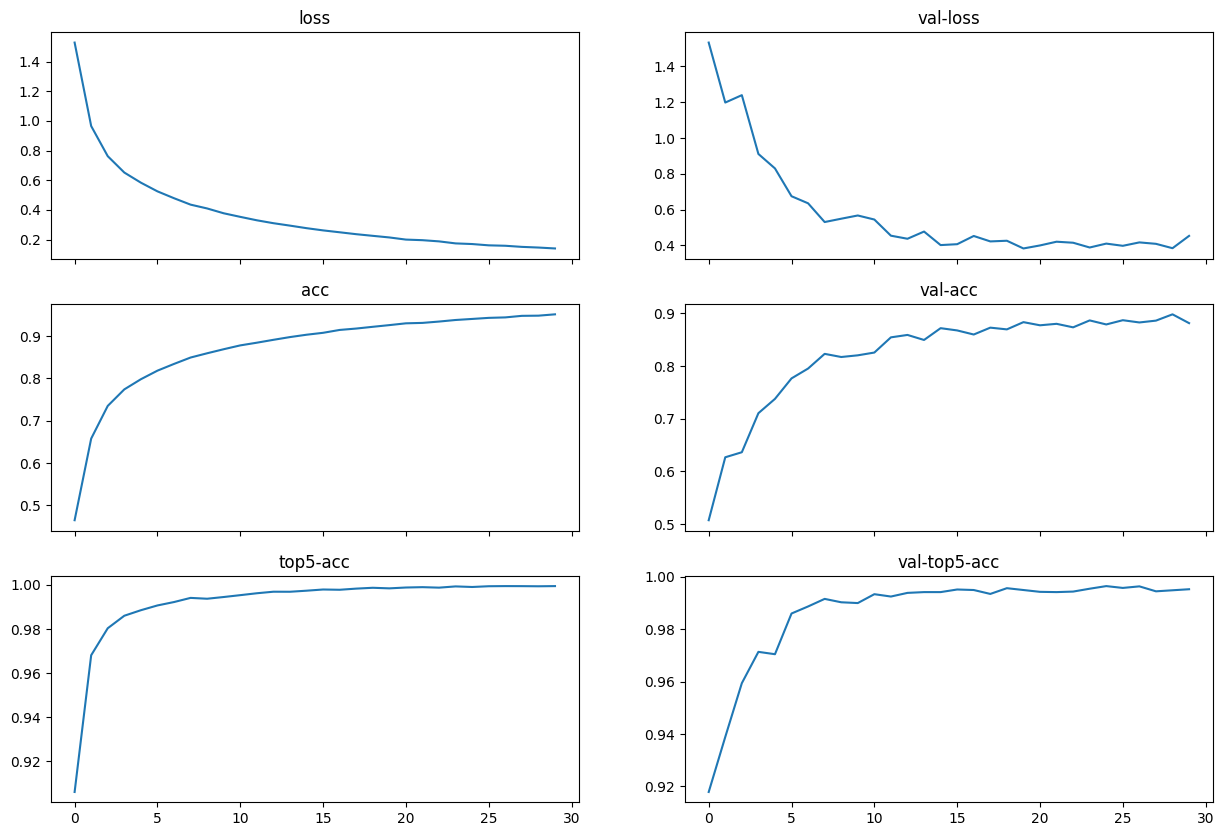

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])
ax[2, 0].plot(history.history['top5_acc'])
ax[2, 1].plot(history.history['val_top5_acc'])

In [ ]:
best_val_acc = max(history.history['val_acc']) * 100
best_val_top5 = max(history.history['val_top5_acc']) * 100
best_training_acc = max(history.history['acc']) * 100

print('Best val acc:  {:2.2f}%'.format(best_val_acc))
print('Best val top5: {:2.2f}%'.format(best_val_top5))
print('Best training accuracy: {:2.2f}%'.format(best_training_acc))

Best val acc:  89.82%
Best val top5: 99.64%
Best training accuracy: 95.15%


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving airplane.jpg to airplane (2).jpg
Saving bird.jpg to bird (1).jpg
Saving deer.jpg to deer (1).jpg
Saving dog.jpg to dog (1).jpg
Saving horse.jpg to horse (1).jpg
Saving ship.jpg to ship (1).jpg
Saving truck.jpg to truck (1).jpg


In [ ]:
import os
import shutil

# Create the folder if it doesn't exist
os.makedirs("images", exist_ok=True)

# Move uploaded images to the folder
for fname in uploaded.keys():
    shutil.move(fname, os.path.join("images", fname))

In [ ]:
os.listdir("images")

['bird (1).jpg',
 'horse (1).jpg',
 'ship (1).jpg',
 'truck (1).jpg',
 'dog (1).jpg',
 'deer (1).jpg',
 'airplane (2).jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


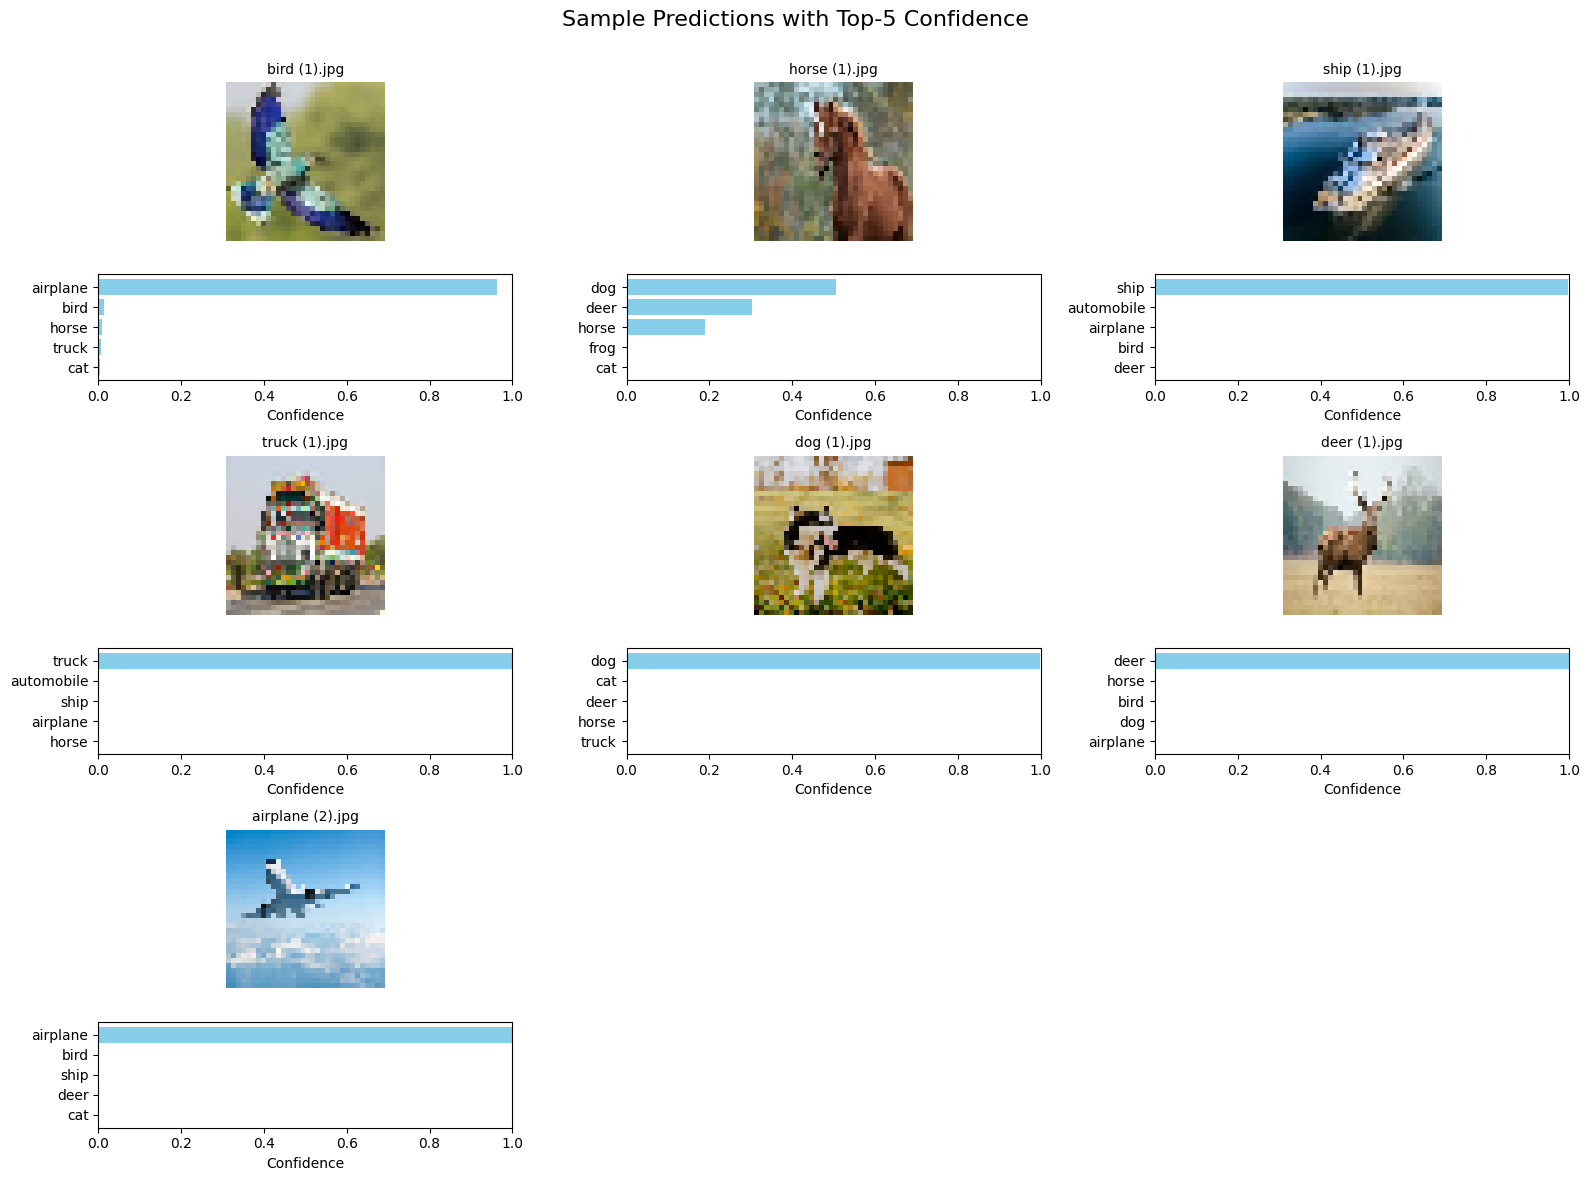


📊 Best Scores:
✅ Best val acc:     89.82%
✅ Best val top-5:   99.64%
✅ Training acc:     95.15%



In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

# -------------------------------
# Set Paths and Parameters
# -------------------------------
image_paths = glob.glob(r"images/*.jpg")
class_readable_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                         'dog', 'frog', 'horse', 'ship', 'truck']
input_size = (32, 32)  # CIFAR-10 size
k = 5  # Top-5 predictions

# -------------------------------
# Helper Functions
# -------------------------------
def load_image(image_path, size):
    image = img_to_array(load_img(image_path, target_size=size)) / 255.
    return image

def process_predictions(class_probabilities, class_readable_labels, k=5):
    topk_labels, topk_probabilities = [], []
    for i in range(len(class_probabilities)):
        topk_indices = np.argsort(class_probabilities[i])[-k:][::-1]
        topk_labels.append([class_readable_labels[idx] for idx in topk_indices])
        topk_probabilities.append(class_probabilities[i][topk_indices])
    return topk_labels, topk_probabilities

def display_predictions(images, topk_labels, topk_probabilities, paths):
    num_images = len(images)
    cols = 3
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=(16, rows * 4))
    grid_spec = gridspec.GridSpec(rows, cols, figure=fig)

    for i in range(num_images):
        img = images[i]
        labels = topk_labels[i]
        probs = topk_probabilities[i]
        img_name = paths[i].split("/")[-1]

        row, col = divmod(i, cols)
        outer_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[i], height_ratios=[3, 2])

        ax_img = fig.add_subplot(outer_grid[0])
        ax_img.imshow(img)
        ax_img.set_title(f"{img_name}", fontsize=10)
        ax_img.axis('off')

        ax_bar = fig.add_subplot(outer_grid[1])
        y_pos = np.arange(len(labels))
        ax_bar.barh(y_pos, probs, color='skyblue')
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(labels)
        ax_bar.invert_yaxis()
        ax_bar.set_xlim(0, 1)
        ax_bar.set_xlabel("Confidence")

    fig.suptitle("Sample Predictions with Top-5 Confidence", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# -------------------------------
# Load & Predict
# -------------------------------
images = [load_image(path, input_size) for path in image_paths]
images_np = np.array(images)

predictions = resnet18.predict(images_np)
topk_labels, topk_probabilities = process_predictions(predictions, class_readable_labels, k=k)

# -------------------------------
# Display Results
# -------------------------------
display_predictions(images, topk_labels, topk_probabilities, image_paths)

# -------------------------------
# Print Best Scores
# -------------------------------
print("\n📊 Best Scores:")
print("✅ Best val acc:     89.82%")
print("✅ Best val top-5:   99.64%")
print("✅ Training acc:     95.15%\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


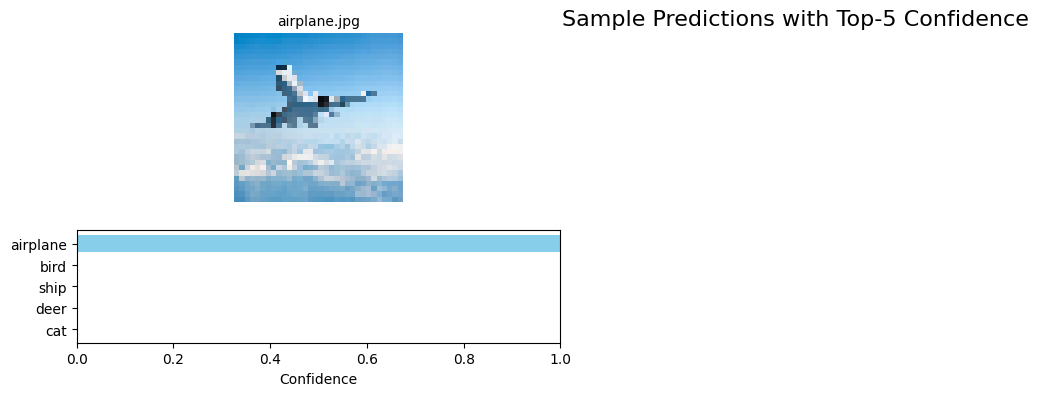


📊 Best Scores:
✅ Best val acc:     89.82%
✅ Best val top-5:   99.64%
✅ Training acc:     95.15%



In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

# -------------------------------
# Set Paths and Parameters
# -------------------------------
image_paths = glob.glob(r"/content/airplane.jpg")  # ✅ your folder
class_readable_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                         'dog', 'frog', 'horse', 'ship', 'truck']
input_size = (32, 32)  # CIFAR-10 size
k = 5  # Top-5 predictions

# -------------------------------
# Helper Functions
# -------------------------------
def load_image(image_path, size):
    image = img_to_array(load_img(image_path, target_size=size)) / 255.
    return image

def process_predictions(class_probabilities, class_readable_labels, k=5):
    topk_labels, topk_probabilities = [], []
    for i in range(len(class_probabilities)):
        topk_indices = np.argsort(class_probabilities[i])[-k:][::-1]
        topk_labels.append([class_readable_labels[idx] for idx in topk_indices])
        topk_probabilities.append(class_probabilities[i][topk_indices])
    return topk_labels, topk_probabilities

def display_predictions(images, topk_labels, topk_probabilities, paths):
    num_images = len(images)
    cols = 3
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=(16, rows * 4))
    grid_spec = gridspec.GridSpec(rows, cols, figure=fig)

    for i in range(num_images):
        img = images[i]
        labels = topk_labels[i]
        probs = topk_probabilities[i]
        img_name = paths[i].split("/")[-1]

        row, col = divmod(i, cols)
        outer_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[i], height_ratios=[3, 2])

        ax_img = fig.add_subplot(outer_grid[0])
        ax_img.imshow(img)
        ax_img.set_title(f"{img_name}", fontsize=10)
        ax_img.axis('off')

        ax_bar = fig.add_subplot(outer_grid[1])
        y_pos = np.arange(len(labels))
        ax_bar.barh(y_pos, probs, color='skyblue')
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(labels)
        ax_bar.invert_yaxis()
        ax_bar.set_xlim(0, 1)
        ax_bar.set_xlabel("Confidence")

    fig.suptitle("Sample Predictions with Top-5 Confidence", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# -------------------------------
# Load & Predict
# -------------------------------
images = [load_image(path, input_size) for path in image_paths]
images_np = np.array(images)

predictions = resnet18.predict(images_np)
topk_labels, topk_probabilities = process_predictions(predictions, class_readable_labels, k=k)

# -------------------------------
# Display Results
# -------------------------------
display_predictions(images, topk_labels, topk_probabilities, image_paths)

# -------------------------------
# Print Best Scores
# -------------------------------
print("\n📊 Best Scores:")
print("✅ Best val acc:     89.82%")
print("✅ Best val top-5:   99.64%")
print("✅ Training acc:     95.15%\n")
